In [29]:
import pandas as pd  
import numpy as np   
import matplotlib.pyplot as plt  
import matplotlib.font_manager as fm
import platform
import seaborn as sns  
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)


In [5]:
# CSV 파일 읽기 (파일 이름과 경로는 실제 환경에 맞게 바꿔주세요)
train = pd.read_csv('train.csv', encoding='utf-8')

# 데이터 기본 정보 확인
print(train.info())
print(train.head())

# 운영체제별 한글 폰트 경로 설정
if platform.system() == 'Windows':
    font_path = 'C:/Windows/Fonts/malgun.ttf'  # 맑은 고딕
elif platform.system() == 'Darwin':
    font_path = '/System/Library/Fonts/Supplemental/AppleGothic.ttf'  # Mac 한글폰트
else:
    font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'  # 리눅스 나눔고딕 (설치 필요)
    
# 폰트 적용
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)

# 마이너스 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10836 entries, 0 to 10835
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   item_id   10836 non-null  object 
 1   year      10836 non-null  int64  
 2   month     10836 non-null  int64  
 3   seq       10836 non-null  float64
 4   type      10836 non-null  int64  
 5   hs4       10836 non-null  int64  
 6   weight    10836 non-null  float64
 7   quantity  10836 non-null  float64
 8   value     10836 non-null  float64
dtypes: float64(4), int64(4), object(1)
memory usage: 762.0+ KB
None
    item_id  year  month  seq  type   hs4    weight  quantity     value
0  DEWLVASR  2022      1  1.0     1  3038   14858.0       0.0   32688.0
1  ELQGMQWE  2022      1  1.0     1  2002   62195.0       0.0  110617.0
2  AHMDUILJ  2022      1  1.0     1  2102   18426.0       0.0   72766.0
3  XIPPENFQ  2022      1  1.0     1  2501   20426.0       0.0   11172.0
4  FTSVTTSR  2022      1  1.0     

무게가 0인데 가치가 있는 경우: 예를 들어, 전자문서, 소프트웨어, 라이선스, 지적재산권과 같이 물리적 무게가 거의 없거나 0에 가까운 품목도 무역 거래가 이루어지며, 이 경우 가치만 존재합니다.

가치가 0인데 무게가 있는 경우: 시료용 샘플, 저가 물품, 또는 신고 오류 등으로 무게만 입력되고 가치가 누락된 경우가 있을 수 있습니다.

데이터 수집 및 신고 오류: 무역 통관 과정에서 실무자가 실수하거나 시스템 문제로 무게 또는 가치 데이터가 누락되거나 잘못 기록될 수 있습니다.

비관세장벽 및 제도적 이유: 일부 수입품에 대해 과세 목적이나 통계 분류상 특수한 처리로 인해 무게나 가치가 비정상적으로 처리될 가능성도 존재합니다.

In [6]:
# 논리 불일치 데이터 탐색 및 제거

mask_value0_weight_pos = (train['value'] == 0) & (train['weight'] > 0)
mask_weight0_value_pos = (train['weight'] == 0) & (train['value'] > 0)
inconsistent_rows = train[mask_value0_weight_pos | mask_weight0_value_pos]

print(f'논리 불일치 행 수: {len(inconsistent_rows)}')

# 불일치 데이터 제거
train = train[~(mask_value0_weight_pos | mask_weight0_value_pos)].reset_index(drop=True)
print(f'정제 후 데이터 shape: {train.shape}')

논리 불일치 행 수: 301
정제 후 데이터 shape: (10535, 9)


item_id     0
year        0
month       0
seq         0
type        0
hs4         0
weight      0
quantity    0
value       0
dtype: int64


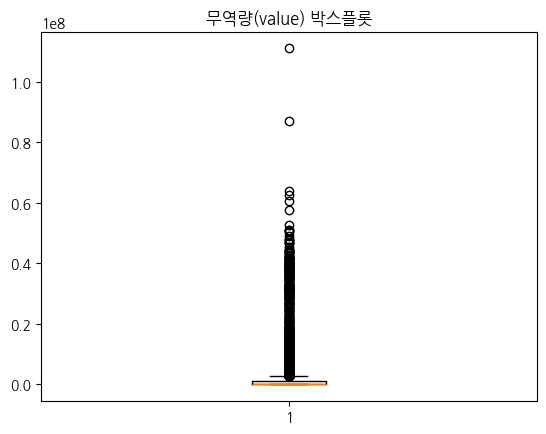

In [7]:
# 결측치 및 이상치 확인

print(train.isnull().sum())

import matplotlib.pyplot as plt
plt.boxplot(train['value'])
plt.title('무역량(value) 박스플롯')
plt.show()


In [8]:
# 품목별 월별 시계열 누락 데이터 확인 및 보완
# 누락된 월이 있다면 0 또는 적절한 값으로 채워 시계열 연속성을 보장해야 함
all_months = pd.date_range(start='2022-01-01', end='2025-07-01', freq='MS')

def fill_missing_months(group):
    item_id = group.name 
    # year, month로 date 생성
    group['date'] = pd.to_datetime(group[['year', 'month']].assign(day=1))
    # 중복된 date 제거 (가장 처음 행만 남김)
    group = group.drop_duplicates(subset='date')
    # date를 인덱스로 설정 후 전체 기간 재색인
    group = group.set_index('date').reindex(all_months).fillna(0).reset_index()
    group['year'] = group['index'].dt.year
    group['month'] = group['index'].dt.month
    group = group.drop(columns=['index'])
    group['item_id'] = item_id
    # 정리 후 반환
    return group

train_filled = train.groupby('item_id', group_keys=False).apply(fill_missing_months, include_groups=False).reset_index(drop=True)
print(f'보완 후 데이터 shape: {train_filled.shape}')
print(train_filled.head())


보완 후 데이터 shape: (4300, 9)
   year  month  seq  type     hs4   weight  quantity    value   item_id
0  2022      1  2.0   1.0  4810.0  17625.0       0.0  14276.0  AANGBULD
1  2022      2  3.0   1.0  4810.0  67983.0       0.0  52347.0  AANGBULD
2  2022      3  2.0   1.0  4810.0  69544.0       0.0  53549.0  AANGBULD
3  2022      4  0.0   0.0     0.0      0.0       0.0      0.0  AANGBULD
4  2022      5  2.0   1.0  4810.0  34173.0       0.0  26997.0  AANGBULD


In [9]:
# 품목별 시계열 통계 및 변화율 계산
# 각 품목별 무역량(value)에 대해 평균, 표준편차, 월별 변화율(증감률)을 산출해 시계열 특성 강화

train_filled['value_change_rate'] = train_filled.groupby('item_id')['value'].transform(lambda x: x.pct_change().fillna(0))
stats = train_filled.groupby('item_id')['value'].agg(['mean', 'std']).reset_index()
print(stats.head())


    item_id          mean           std
0  AANGBULD  6.519807e+04  1.221743e+05
1  AHMDUILJ  4.429323e+04  3.808460e+04
2  ANWUJOKX  6.849093e+03  1.629458e+04
3  APQGTRMF  1.426705e+05  1.150632e+05
4  ATLDMDBO  2.038085e+07  1.996461e+07


HS 코드(4자리)는 국제 무역에서 품목을 분류하는 체계로, 일반적으로 대분류(2자리), 중분류(4자리), 소분류(6자리 이상)로 세분화

주어진 hs4 4자리 코드를 바탕으로 **대분류(2자리)**와 중분류(4자리)를 도출해 분석에 활용

품목별 공행성 분석 전에 상위 분류별로 묶어보면 비슷한 무역 패턴, 공급망 특성을 가진 그룹이 나올 수 있어 노이즈가 줄고 인사이트 확보에 도움

  major_cls           mean            std
0        00       0.000000       0.000000
1        12  200026.953488  241044.313837
2        20  122789.465116   94057.475752
3        21   44293.232558   38084.596457
4        25  166327.398438  341347.380922


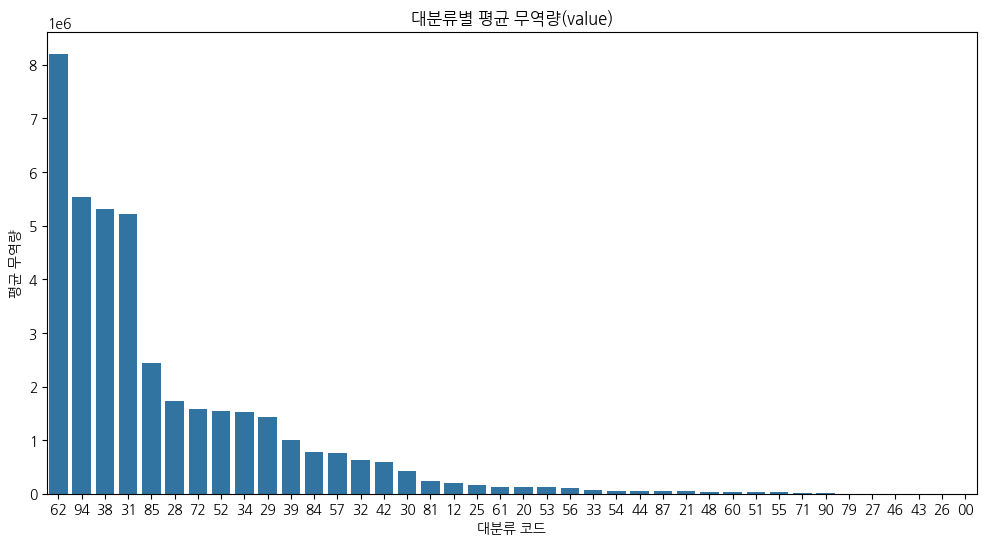

In [10]:
# hs4를 문자열로 변환하고 4자리 맞춤 (필요 시)
train_filled['hs4_str'] = train_filled['hs4'].astype(int).astype(str).str.zfill(4)

# 대분류(2자리 접두어)
train_filled['major_cls'] = train_filled['hs4_str'].str[:2]

# 중분류는 4자리 그대로 사용
train_filled['mid_cls'] = train_filled['hs4_str']

# 대분류별 무역량(value) 평균 및 표준편차
major_stats = train_filled.groupby('major_cls')['value'].agg(['mean', 'std']).reset_index()
print(major_stats.head())

# 시각화: 대분류별 평균 무역량
plt.figure(figsize=(12,6))
sns.barplot(data=major_stats.sort_values('mean', ascending=False), x='major_cls', y='mean')
plt.title('대분류별 평균 무역량(value)')
plt.xlabel('대분류 코드')
plt.ylabel('평균 무역량')
plt.show()

In [11]:
# HS4 4자리별 총 무역량
hs4_total = train_filled.groupby('hs4')['value'].sum().sort_values(ascending=False)
print("HS4별 총 무역량 상위 10개:")
print(hs4_total.head(10))

# 누적 비율 계산
hs4_df = pd.DataFrame({
    'hs4': hs4_total.index,
    'value': hs4_total.values
})
hs4_df['cum_sum'] = hs4_df['value'].cumsum()
hs4_df['cum_perc'] = (hs4_df['cum_sum'] / hs4_df['value'].sum()) * 100

print("\n전체 무역량의 80%를 차지하는 HS4 코드:")
print(hs4_df[hs4_df['cum_perc'] <= 80])


HS4별 총 무역량 상위 10개:
hs4
3824.0    1.553574e+09
2814.0    8.763765e+08
8505.0    5.097235e+08
3102.0    4.488151e+08
3815.0    4.075558e+08
6211.0    3.529206e+08
8501.0    2.527834e+08
9403.0    2.378176e+08
2811.0    2.364209e+08
7207.0    1.274464e+08
Name: value, dtype: float64

전체 무역량의 80%를 차지하는 HS4 코드:
      hs4         value       cum_sum   cum_perc
0  3824.0  1.553574e+09  1.553574e+09  25.494405
1  2814.0  8.763765e+08  2.429950e+09  39.875889
2  8505.0  5.097235e+08  2.939674e+09  48.240536
3  3102.0  4.488151e+08  3.388489e+09  55.605666
4  3815.0  4.075558e+08  3.796045e+09  62.293725
5  6211.0  3.529206e+08  4.148965e+09  68.085211
6  8501.0  2.527834e+08  4.401749e+09  72.233429
7  9403.0  2.378176e+08  4.639567e+09  76.136055


| 코드 | 품목군명          | 코드 | 품목군명            |
|-------|------------------|-------|--------------------|
| 00    | 살아있는 동물      | 44    | 목재 및 목재제품     |
| 12    | 기름 및 기름 씨앗  | 46    | 짚, 바구니류 등      |
| 20    | 채소, 과일, 견과류 | 51    | 양모 및 면          |
| 21    | 식료품 및 음료      | 52    | 면                  |
| 25    | 광물성 연료, 왁스  | 53    | 기타 식물성 섬유     |
| 26    | 광석 및 광물       | 54    | 합성 섬유           |
| 27    | 광물성 연료 및 정유 | 55    | 합성 섬유           |
| 28    | 무기 화학품 및 동위원소 | 56    | 기타 직물용 섬유     |
| 29    | 유기화학품         | 57    | 직물용 섬유실        |
| 30    | 의약품             | 60    | 편직물              |
| 31    | 비료               | 61    | 의류 및 의복 액세서리|
| 32    | 염료, 타닌, 염료용 물질 | 62    | 의류 및 액세서리 (편물 제외) |
| 33    | 향료 및 화장품     | 71    | 귀금속, 보석        |
| 38    | 비누, 유기표면활성제| 72    | 철강                |
| 39    | 플라스틱 및 플라스틱 제품 | 79    | 아연 및 그 제품      |
| 42    | 가죽, 여행용품     | 81    | 조립금속 및 기타     |
| 43    | 모피               | 84    | 기계류              |
| 48    | 종이 및 종이제품  | 85    | 전기기기            |
| 49    | 도서 및 인쇄물     | 87    | 차량 및 관련 부품   |
| 50    | 실크               | 90    | 광학기기 및 계측기기|
| 54    | 합성 섬유          | 94    | 가구, 조명 및 기타   |


In [12]:
print(train_filled['major_cls'].unique())

['48' '00' '21' '44' '81' '28' '55' '32' '90' '31' '94' '62' '56' '30'
 '38' '20' '34' '79' '87' '25' '27' '71' '85' '60' '12' '46' '39' '51'
 '84' '72' '57' '54' '33' '42' '29' '26' '43' '61' '53' '52']


62, 94, 38, 31번 대분류: 평균 무역량이 매우 높아, 이 영역의 품목들이 전체 무역에서 많은 비중을 차지함을 의미

 | 62    | 의류 및 액세서리 (편물 제외) 

 편물(knit, 니트): 실을 고리 형식으로 짜는 방식으로, 뜨개질로 만든 목도리처럼 잘 늘어나는 성질이 있습니다. → HS 61류에 분류'
 예: 티셔츠, 니트, 후드티 등
 직물(woven): 날실과 씨실을 직각으로 교차해서 짠 천으로, 편물이 아닌 일반 천입니다. → HS 62류에 분류
 계절별 패턴, 패션 트렌드 변화에 민감하므로 월별 변동 추적 중요
 공행성 예상: 같은 의류군(61류 편물 의류)이나 섬유 관련 품목(52~60류)과 연관성 높을 가능성

 | 94    | 가구, 조명 및 기타 
 특징: 내구재이므로 경기 변동, 부동산 경기와 연동 가능성
 공행성 예상: 건설/인테리어 관련 품목(목재 44류, 플라스틱 39류 등)과 연관

 | 38    | 비누, 유기표면활성제 
 특징: 산업 원자재 및 소비재의 중간적 성격
 공행성 예상: 화학품군(28, 29류 무기/유기화학품)과 높은 연관성

 | 31    | 비료             
 특징: 농업 생산과 직결되며 계절성(파종기, 수확기) 영향 큼
 공행성 예상: 농산물 관련 품목, 화학품(28류 무기화학품) 등과 연관 


In [13]:
# 품목 간 시계열 상관관계 분석 (공행성 탐색 기초)
# 월별 pivot 테이블 생성 (품목별 value)
pivot_df = train_filled.pivot_table(
    index=['year', 'month'], 
    columns='item_id', 
    values='value', 
    fill_value=0
)

# 상관계수 매트릭스 계산
corr_matrix = pivot_df.corr()

# 상관계수 절대값 기준 상위 쌍 추출
import numpy as np
corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_pairs.append({
            'item_A': corr_matrix.columns[i],
            'item_B': corr_matrix.columns[j],
            'correlation': corr_matrix.iloc[i, j]
        })

corr_df = pd.DataFrame(corr_pairs).sort_values('correlation', ascending=False)
print(corr_df.head(20))  # 상관도 높은 상위 20쌍

        item_A    item_B  correlation
3263  KFQSHBNH  RJCAXSGH     0.933778
3379  LLHREMKS  RUVXNNVA     0.847964
3295  KFQSHBNH  ZKENOUDA     0.772425
2313  FTSVTTSR  XIIEJNEE     0.730613
4262  QSDCUCLB  UGEQLMXM     0.693251
4420  RJCAXSGH  ZKENOUDA     0.678749
979   BTMOEMEP  LRVGFDFM     0.650141
3332  KJNSOAHR  UGEQLMXM     0.639956
2250  FTSVTTSR  GIKPEWTY     0.631408
1517  DJBLNPNC  SAAYMURU     0.628102
920   BSRMSVTC  SUOYXCHP     0.622602
1952  FDXPMYGF  GIKPEWTY     0.617965
1623  DNMPSKTB  XUOIQPFL     0.615778
4302  QVLMOEYE  VBYCLTYZ     0.612083
2504  GKQIJYDH  RUVXNNVA     0.603144
3292  KFQSHBNH  YSYHGLQK     0.593918
4210  QRKRBYJL  QVLMOEYE     0.593907
1836  EVBVXETX  RJGPVEXX     0.591643
3998  OKMBFVKS  XUOIQPFL     0.581296
2635  GYHKIVQT  QVLMOEYE     0.579055


### 왜 Lag가 중요한가?
무역에서는 공급망 관계나 산업 연쇄 효과 때문에 시차가 발생합니다:

원자재 → 완제품: 원자재(예: 화학품) 수입 증가 → 1~2개월 후 완제품(예: 가구, 의류) 수입 증가

계절성: 특정 품목 수입 증가 → 몇 개월 후 관련 품목 수입 증가

경제 지표: 경기 변화가 품목별로 다른 시차를 두고 영향을 줌

### 대회에서의 활용
Lag 0 (동시 공행성): 같은 달에 함께 움직임 → 공행성 판별에는 유효하지만, 예측에는 제한적

Lag 1~3 (선후행 관계): 선행 품목의 현재 데이터로 후행 품목의 미래(1~3개월 후)를 예측 가능 → 예측 모델에 유리

In [14]:
# 시차(lag) 교차상관 분석 (선후행 관계 탐색)
from scipy.stats import pearsonr

def cross_correlation_lag(series_A, series_B, max_lag=3):
    """시차별 상관계수 계산"""
    results = {}
    for lag in range(0, max_lag+1):
        if lag == 0:
            corr, _ = pearsonr(series_A, series_B)
        else:
            corr, _ = pearsonr(series_A[:-lag], series_B[lag:])
        results[lag] = corr
    return results

# 예시: 특정 두 품목 간 시차 상관
item_A_series = pivot_df['KFQSHBNH']
item_B_series = pivot_df['RJCAXSGH']
lag_corr = cross_correlation_lag(item_A_series, item_B_series, max_lag=3)
print(lag_corr)


{0: np.float64(0.9337779009208362), 1: np.float64(0.7583920434967101), 2: np.float64(0.6959813159135366), 3: np.float64(0.7673196812176807)}


Lag 0이 가장 높으므로 두 품목은 같은 달에 함께 움직이는 동시성 공행성이 강함

다만 Lag 3에서도 상관이 높아 복잡한 시차 패턴이 존재할 가능성이 있음

이는 선후행 관계라기보다는 동조 변동에 가까움

In [15]:
# 모든 고상관 쌍에 대해 시차 교차상관 계산
def find_lead_lag_pairs(corr_df, pivot_df, top_n=20, max_lag=3):
    results = []
    for idx, row in corr_df.head(top_n).iterrows():
        item_A = row['item_A']
        item_B = row['item_B']
        
        series_A = pivot_df[item_A]
        series_B = pivot_df[item_B]
        
        lag_corr = cross_correlation_lag(series_A, series_B, max_lag=max_lag)
        
        # lag 0 대비 lag 1~2가 높은지 확인
        best_lag = max(lag_corr, key=lag_corr.get)
        
        results.append({
            'item_A': item_A,
            'item_B': item_B,
            'corr_lag0': lag_corr[0],
            'best_lag': best_lag,
            'best_corr': lag_corr[best_lag]
        })
    
    return pd.DataFrame(results)

lead_lag_df = find_lead_lag_pairs(corr_df, pivot_df, top_n=50)
# Lag 1~3이 최적인 쌍 필터링
lead_lag_pairs = lead_lag_df[lead_lag_df['best_lag'] > 0]
print(lead_lag_pairs.head(20))

      item_A    item_B  corr_lag0  best_lag  best_corr
16  QRKRBYJL  QVLMOEYE   0.593907         2   0.665094


QRKRBYJL → QVLMOEYE (Lag 2)
Lag 0: 0.594

Lag 2: 0.665 (최고)

해석: QRKRBYJL 품목이 변화한 후 2개월 뒤 QVLMOEYE가 따라 움직이는 선후행 관계

활용: QRKRBYJL의 현재 데이터로 QVLMOEYE의 2개월 후 무역량 예측 가능

나머지 쌍들
대부분 Lag 0이 최고 → 동시성 공행성

이는 두 품목이 같은 경제 요인, 산업 트렌드에 동시에 반응함을 의미

대회 규칙상 "공행성 쌍"을 판별하는 것이므로, 동시성(Lag 0)도 공행성의 일종 

다만 예측 시에는:

선행 품목의 현재 달 데이터로 후행 품목의 다음 달을 예측

또는 두 품목 모두 같은 외부 요인(경기, 계절)에 영향받으므로 시계열 특징 공유 전략

In [16]:
# 상위 50~100개 쌍으로 확대
lead_lag_df = find_lead_lag_pairs(corr_df, pivot_df, top_n=100, max_lag=3)
lead_lag_pairs = lead_lag_df[lead_lag_df['best_lag'] > 0]
print(f"선후행 쌍 개수: {len(lead_lag_pairs)}")
print(lead_lag_pairs.sort_values('best_corr', ascending=False).head(20))


선후행 쌍 개수: 9
      item_A    item_B  corr_lag0  best_lag  best_corr
61  ATLDMDBO  BTMOEMEP   0.467754         1   0.792072
87  DNMPSKTB  OGAFEHLU   0.436788         2   0.687565
16  QRKRBYJL  QVLMOEYE   0.593907         2   0.665094
71  LRVGFDFM  OGAFEHLU   0.454512         2   0.620242
68  ATLDMDBO  UXSPKBJR   0.459320         3   0.582287
72  JPBRUTWP  QVLMOEYE   0.453458         2   0.535816
76  OGAFEHLU  SDWAYPIK   0.447762         2   0.495840
97  ELQGMQWE  RJCAXSGH   0.423666         1   0.490643
79  OGAFEHLU  OKMBFVKS   0.444025         2   0.467714


In [17]:
# 품목 정보 추출
item_info = train_filled.groupby('item_id').agg({
    'hs4': 'first',
    'major_cls': 'first', # 대분류
    'value': 'mean'  # 평균 무역량
}).reset_index()

# 선후행 쌍에 정보 추가
lead_lag_pairs_info = lead_lag_pairs.merge(
    item_info.rename(columns={
        'item_id': 'item_A', 
        'hs4': 'hs4_A', 
        'major_cls': 'major_A',
        'value': 'mean_value_A'
    }),
    on='item_A'
).merge(
    item_info.rename(columns={
        'item_id': 'item_B', 
        'hs4': 'hs4_B', 
        'major_cls': 'major_B',
        'value': 'mean_value_B'
    }),
    on='item_B'
)

print(lead_lag_pairs_info[['item_A', 'item_B', 'best_lag', 'best_corr', 'major_A', 'major_B']])


     item_A    item_B  best_lag  best_corr major_A major_B
0  QRKRBYJL  QVLMOEYE         2   0.665094      28      42
1  ATLDMDBO  BTMOEMEP         1   0.792072      28      31
2  ATLDMDBO  UXSPKBJR         3   0.582287      28      32
3  LRVGFDFM  OGAFEHLU         2   0.620242      31      72
4  JPBRUTWP  QVLMOEYE         2   0.535816      39      42
5  OGAFEHLU  SDWAYPIK         2   0.495840      72      72
6  OGAFEHLU  OKMBFVKS         2   0.467714      72      57
7  DNMPSKTB  OGAFEHLU         2   0.687565      28      72
8  ELQGMQWE  RJCAXSGH         1   0.490643      20      00


### 주요 패턴 해석
순위	선행 품목	후행 품목	Lag	상관	선행 산업	후행 산업	해석

1	ATLDMDBO	BTMOEMEP	1	0.792	28 (무기화학품)	31 (비료)	화학품 → 비료

2	DNMPSKTB	OGAFEHLU	2	0.688	28 (무기화학품)	72 (철강)	화학품 → 철강

3	QRKRBYJL	QVLMOEYE	2	0.665	28 (무기화학품)	42 (가죽제품)	화학품 → 가죽

4	LRVGFDFM	OGAFEHLU	2	0.620	31 (비료)	72 (철강)	비료 → 철강

5	ATLDMDBO	UXSPKBJR	3	0.582	28 (무기화학품)	32 (염료)	화학품 → 염료

### 핵심 인사이트
무기화학품(28류)이 핵심 선행 품목: 9개 중 5개가 무기화학품에서 시작

화학품 → 비료, 철강, 가죽, 염료로 연결

산업 원자재 특성: 화학품이 다양한 산업의 원료로 사용됨을 시사

철강(72류)이 자주 등장하는 후행 품목:

화학품 → 철강, 비료 → 철강

철강 생산에 화학품이 필요하고, 철강끼리도 연관성(72→72)

### 공급망 관계 명확:

무기화학품(28) → 비료(31): 비료 생산에 화학품 필요

무기화학품(28) → 염료(32): 염료 제조에 화학품 원료 사용

플라스틱(39) → 가죽제품(42): 플라스틱 가공 후 제품 제조

In [18]:
# 데이터 준비
item_A = 'ATLDMDBO'
item_B = 'BTMOEMEP'
lag = 1

X = pivot_df[item_A].values[:-lag].reshape(-1, 1)
y = pivot_df[item_B].values[lag:]

# 시계열 분할 (마지막 20%를 테스트)
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# 선형회귀 모델
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# 평가
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
nmae = mae / (np.mean(np.abs(y_test)) + 1e-8)

print(f"선행: 무기화학품(28) → 후행: 비료(31)")
print(f"R2 Score: {r2:.4f}")
print(f"MAE: {mae:.2f}")
print(f"NMAE: {nmae:.4f}")


선행: 무기화학품(28) → 후행: 비료(31)
R2 Score: -0.2475
MAE: 1992314.50
NMAE: 0.4478


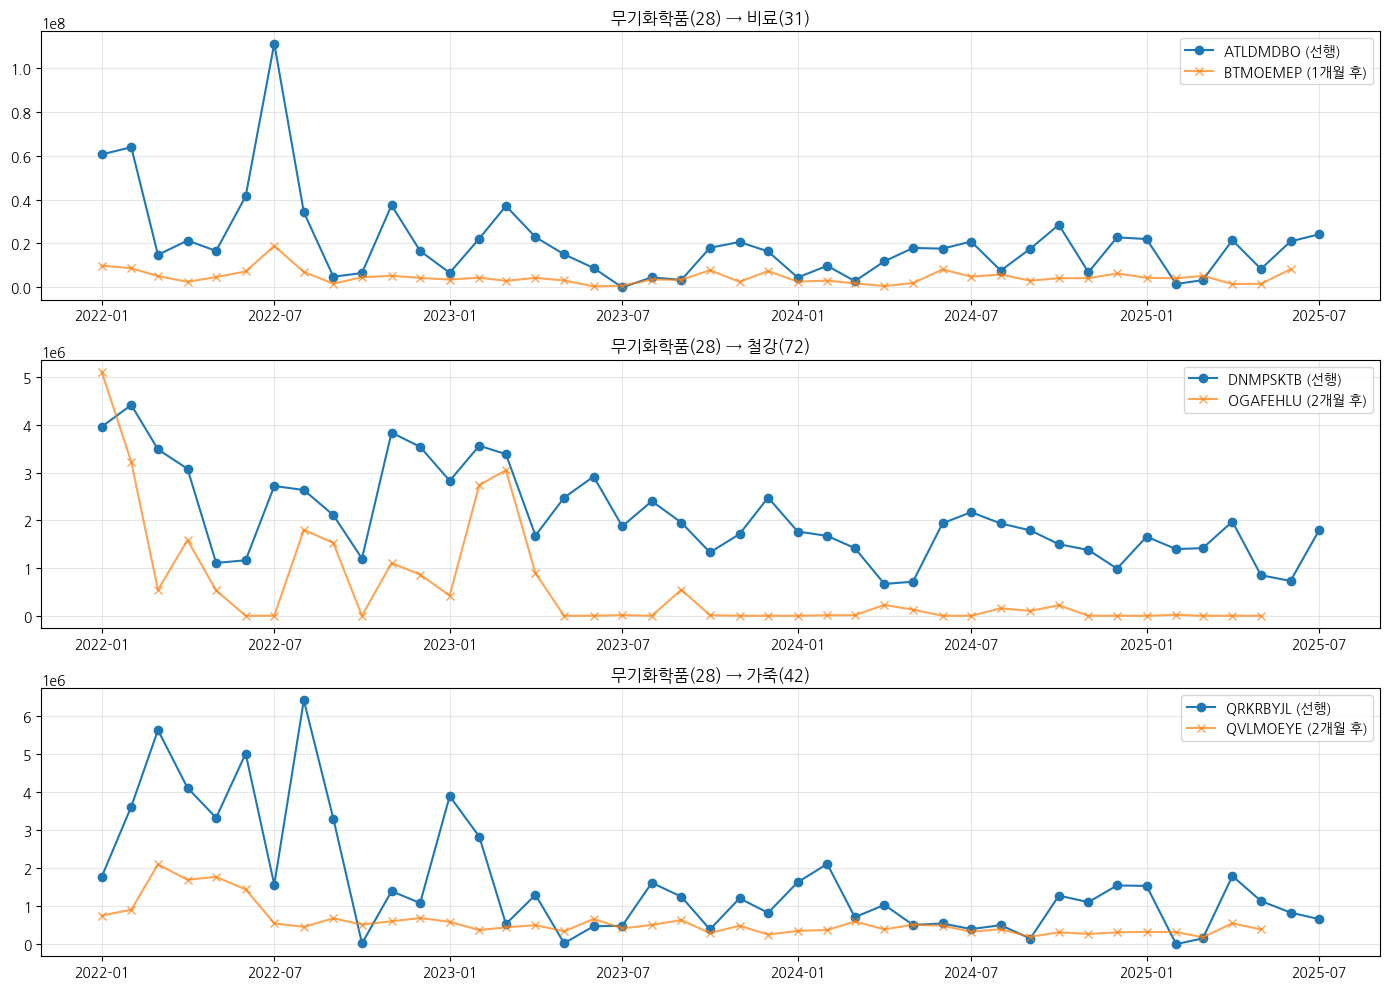

In [19]:
import matplotlib.pyplot as plt

# 상위 3개 선후행 쌍 시각화
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

pairs_to_plot = [
    ('ATLDMDBO', 'BTMOEMEP', 1, '무기화학품(28) → 비료(31)'),
    ('DNMPSKTB', 'OGAFEHLU', 2, '무기화학품(28) → 철강(72)'),
    ('QRKRBYJL', 'QVLMOEYE', 2, '무기화학품(28) → 가죽(42)')
]

# pivot_df의 MultiIndex (year, month)를 datetime으로 변환하여 x축으로 사용
time_index = pd.to_datetime([f"{int(y)}-{int(m):02d}-01" for y, m in pivot_df.index])

for idx, (item_A, item_B, lag, title) in enumerate(pairs_to_plot):
    ax = axes[idx]
    ax.plot(time_index, pivot_df[item_A].values, label=f'{item_A} (선행)', marker='o')
    ax.plot(time_index, pivot_df[item_B].shift(-lag).values, label=f'{item_B} ({lag}개월 후)', marker='x', alpha=0.7)
    ax.set_title(title, fontsize=12)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
plt.tight_layout()
plt.show()


In [20]:
from sklearn.preprocessing import StandardScaler

# 데이터 준비
item_A = 'ATLDMDBO'
item_B = 'BTMOEMEP'
lag = 1

X = pivot_df[item_A].values[:-lag].reshape(-1, 1)
y = pivot_df[item_B].values[lag:]

# 스케일링
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).ravel()

# 시계열 분할
split_idx = int(len(X_scaled) * 0.8)
X_train, X_test = X_scaled[:split_idx], X_scaled[split_idx:]
y_train, y_test = y_scaled[:split_idx], y_scaled[split_idx:]

# 모델 학습
model = LinearRegression()
model.fit(X_train, y_train)
y_pred_scaled = model.predict(X_test)

# 원래 스케일로 복원
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()

# 평가
r2 = r2_score(y_test_original, y_pred)
mae = mean_absolute_error(y_test_original, y_pred)
print(f"정규화 후 R2: {r2:.4f}, MAE: {mae:.2f}")

# 결과가 너무 안좋아서 나머지 예상했던 선후행쌍 시도해보기로 결정


정규화 후 R2: -0.2475, MAE: 1992314.50


In [21]:
# 나머지 8개 쌍에 대해 반복 테스트
pairs_to_test = [
    ('DNMPSKTB', 'OGAFEHLU', 2),
    ('QRKRBYJL', 'QVLMOEYE', 2),
    ('LRVGFDFM', 'OGAFEHLU', 2),
    ('ATLDMDBO', 'UXSPKBJR', 3),
    ('JPBRUTWP', 'QVLMOEYE', 2),
    ('OGAFEHLU', 'SDWAYPIK', 2),
    ('OGAFEHLU', 'OKMBFVKS', 2),
    ('ELQGMQWE', 'RJCAXSGH', 1)
]

for item_A, item_B, lag in pairs_to_test:
    X = pivot_df[item_A].values[:-lag].reshape(-1, 1)
    y = pivot_df[item_B].values[lag:]
    
    split_idx = int(len(X) * 0.8)
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    r2 = r2_score(y_test, y_pred)
    print(f"{item_A} → {item_B} (Lag {lag}): R2 = {r2:.4f}")
    
    # 완전 잘못된 방향인 것 같음 (심각한 음수) -> 허위 상관이거나 비정상 시계열이거나 샘플 수가 너무 적음


DNMPSKTB → OGAFEHLU (Lag 2): R2 = -13.5662
QRKRBYJL → QVLMOEYE (Lag 2): R2 = -3.1583
LRVGFDFM → OGAFEHLU (Lag 2): R2 = -128.7529
ATLDMDBO → UXSPKBJR (Lag 3): R2 = 0.3296
JPBRUTWP → QVLMOEYE (Lag 2): R2 = -6.3463
OGAFEHLU → SDWAYPIK (Lag 2): R2 = -1.0729
OGAFEHLU → OKMBFVKS (Lag 2): R2 = -0.6167
ELQGMQWE → RJCAXSGH (Lag 1): R2 = -2.4505


2025년 7월 값을 그대로 2025년 8월 예측값으로 복사

이것은 "전월값 예측(Naive Forecast)" 또는 "Persistence Model"이라고 불리는 가장 단순한 베이스라인 방법

왜 이렇게 단순한 방법을 택했나?
선후행 관계 모델링 실패: R2 점수가 모두 음수로 나와 선행 품목으로 후행 품목을 예측하는 것이 불가능

데이터 부족: 월별 43개 시점은 복잡한 시계열 모델 학습에 매우 부족

실용적 접근: MAE 비교 결과 전월값이 이동평균보다 오히려 나음 (2,753,550 vs 2,801,955)

In [22]:
# 동시성 공행성 공략

# 1. 공행성 쌍 판별 (동시성 기준)
# 상관계수 0.6 이상을 공행성으로 정의
comovement_pairs = corr_df[corr_df['correlation'].abs() > 0.6].copy()
print(f"공행성 쌍 후보 개수: {len(comovement_pairs)}")
print(comovement_pairs.head(20))

# 2. 후행 품목 예측은 단순 방법 사용
# 방법 A: 이동평균 기반 예측
def predict_with_ma(series, window=3):
    """이동평균 기반 다음달 예측"""
    return series.rolling(window).mean().shift(1)

# 방법 B: 전월값 그대로 사용 (baseline)
def predict_with_last(series):
    """전월값을 다음달 예측값으로"""
    return series.shift(1)

# 예시: BTMOEMEP 예측
pivot_df['BTMOEMEP_pred_ma'] = predict_with_ma(pivot_df['BTMOEMEP'], window=3)
pivot_df['BTMOEMEP_pred_last'] = predict_with_last(pivot_df['BTMOEMEP'])

# 평가
actual = pivot_df['BTMOEMEP'].dropna()
pred_ma = pivot_df['BTMOEMEP_pred_ma'].dropna()
pred_last = pivot_df['BTMOEMEP_pred_last'].dropna()

# 겹치는 인덱스만 사용
common_idx = actual.index.intersection(pred_ma.index)
mae_ma = mean_absolute_error(actual[common_idx], pred_ma[common_idx])
mae_last = mean_absolute_error(actual[common_idx], pred_last[common_idx])

print(f"이동평균 예측 MAE: {mae_ma:.2f}")
print(f"전월값 예측 MAE: {mae_last:.2f}")


공행성 쌍 후보 개수: 15
        item_A    item_B  correlation
3263  KFQSHBNH  RJCAXSGH     0.933778
3379  LLHREMKS  RUVXNNVA     0.847964
3295  KFQSHBNH  ZKENOUDA     0.772425
2313  FTSVTTSR  XIIEJNEE     0.730613
4262  QSDCUCLB  UGEQLMXM     0.693251
4420  RJCAXSGH  ZKENOUDA     0.678749
979   BTMOEMEP  LRVGFDFM     0.650141
3332  KJNSOAHR  UGEQLMXM     0.639956
2250  FTSVTTSR  GIKPEWTY     0.631408
1517  DJBLNPNC  SAAYMURU     0.628102
920   BSRMSVTC  SUOYXCHP     0.622602
1952  FDXPMYGF  GIKPEWTY     0.617965
1623  DNMPSKTB  XUOIQPFL     0.615778
4302  QVLMOEYE  VBYCLTYZ     0.612083
2504  GKQIJYDH  RUVXNNVA     0.603144
이동평균 예측 MAE: 2801955.07
전월값 예측 MAE: 2753550.60


→ 단순히 전월값을 다음달 예측으로 쓰는 게 더 효과적

In [23]:
# 공행성 쌍을 제출 형식으로 변환
comovement_submission = []

for _, row in comovement_pairs.iterrows():
    comovement_submission.append({
        'leading_item': row['item_A'],
        'lagging_item': row['item_B'],
        'comovement': 1,  # 공행성 있음
        'correlation': row['correlation']
    })

comovement_df = pd.DataFrame(comovement_submission)
print(comovement_df)

# CSV 저장
comovement_df.to_csv('comovement_pairs.csv', index=False)
print("공행성 쌍 저장 완료!")


   leading_item lagging_item  comovement  correlation
0      KFQSHBNH     RJCAXSGH           1     0.933778
1      LLHREMKS     RUVXNNVA           1     0.847964
2      KFQSHBNH     ZKENOUDA           1     0.772425
3      FTSVTTSR     XIIEJNEE           1     0.730613
4      QSDCUCLB     UGEQLMXM           1     0.693251
5      RJCAXSGH     ZKENOUDA           1     0.678749
6      BTMOEMEP     LRVGFDFM           1     0.650141
7      KJNSOAHR     UGEQLMXM           1     0.639956
8      FTSVTTSR     GIKPEWTY           1     0.631408
9      DJBLNPNC     SAAYMURU           1     0.628102
10     BSRMSVTC     SUOYXCHP           1     0.622602
11     FDXPMYGF     GIKPEWTY           1     0.617965
12     DNMPSKTB     XUOIQPFL           1     0.615778
13     QVLMOEYE     VBYCLTYZ           1     0.612083
14     GKQIJYDH     RUVXNNVA           1     0.603144
공행성 쌍 저장 완료!


In [24]:
# 1. 공행성 쌍 15개 로드 (이미 comovement_df에 있음)
print(comovement_df.head())

# 2. 각 후행 품목의 2025년 8월 예측값 추가
# 방법: 2025년 7월 값을 그대로 사용 (전월값 베이스라인)

submission_list = []

for _, row in comovement_df.iterrows():
    leading_item = row['leading_item']
    following_item = row['lagging_item']
    
    # 후행 품목의 2025년 7월 값 추출
    july_2025 = train_filled[
        (train_filled['item_id'] == following_item) & 
        (train_filled['year'] == 2025) & 
        (train_filled['month'] == 7)
    ]
    
    if len(july_2025) > 0:
        predicted_value = int(july_2025['value'].values[0])  # 정수형 변환
    else:
        # 데이터 없으면 0 또는 평균값
        avg_value = train_filled[train_filled['item_id'] == following_item]['value'].mean()
        predicted_value = int(avg_value) if not pd.isna(avg_value) else 0
    
    submission_list.append({
        'leading_item_id': leading_item,
        'following_item_id': following_item,
        'value': predicted_value
    })

# 3. 데이터프레임으로 변환
submission_final = pd.DataFrame(submission_list)
print(submission_final)

# 4. CSV 저장
submission_final.to_csv('comovement_15_submission.csv', index=False)
print("\n제출 파일 저장 완료!")
print(f"총 공행성 쌍 수: {len(submission_final)}")


  leading_item lagging_item  comovement  correlation
0     KFQSHBNH     RJCAXSGH           1     0.933778
1     LLHREMKS     RUVXNNVA           1     0.847964
2     KFQSHBNH     ZKENOUDA           1     0.772425
3     FTSVTTSR     XIIEJNEE           1     0.730613
4     QSDCUCLB     UGEQLMXM           1     0.693251
   leading_item_id following_item_id    value
0         KFQSHBNH          RJCAXSGH  2359070
1         LLHREMKS          RUVXNNVA        0
2         KFQSHBNH          ZKENOUDA   202520
3         FTSVTTSR          XIIEJNEE    67526
4         QSDCUCLB          UGEQLMXM     9849
5         RJCAXSGH          ZKENOUDA   202520
6         BTMOEMEP          LRVGFDFM   442803
7         KJNSOAHR          UGEQLMXM     9849
8         FTSVTTSR          GIKPEWTY        0
9         DJBLNPNC          SAAYMURU     1056
10        BSRMSVTC          SUOYXCHP        0
11        FDXPMYGF          GIKPEWTY        0
12        DNMPSKTB          XUOIQPFL   672865
13        QVLMOEYE          VBYCLTYZ  

In [25]:
# fill_missing_months 전후 품목 비교
print(f"원본 품목 수: {train['item_id'].nunique()}")
print(f"보완 후 품목 수: {train_filled['item_id'].nunique()}")

# 제외된 품목
original_items = set(train['item_id'].unique())
filled_items = set(train_filled['item_id'].unique())
excluded_items = original_items - filled_items

print(f"\n제외된 품목 수: {len(excluded_items)}")
print(f"제외된 품목 예시: {list(excluded_items)[:10]}")

# 제외된 품목의 무역량
if excluded_items:
    excluded_value = train[train['item_id'].isin(excluded_items)]['value'].sum()
    total_value = train['value'].sum()
    print(f"제외된 품목 무역량 비율: {excluded_value/total_value:.1%}")


원본 품목 수: 100
보완 후 품목 수: 100

제외된 품목 수: 0
제외된 품목 예시: []


In [26]:
# fill_missing_months 전에 필터링이 있었는지 확인
# 예: 논리 불일치 제거 시 특정 품목 전체가 사라졌을 수 있음

# 품목별 행 수 확인
item_counts = train.groupby('item_id').size()
print(f"품목별 평균 행 수: {item_counts.mean():.1f}")
print(f"품목별 최소 행 수: {item_counts.min()}")
print(f"품목별 최대 행 수: {item_counts.max()}")


품목별 평균 행 수: 105.3
품목별 최소 행 수: 1
품목별 최대 행 수: 129


### Moongs 와 나의 차이
✅ 중복 seq 합산 → 무역량 보존

✅ 월 단위로 깔끔하게 정리

❌ 누락 월은 그대로 누락 (시계열 불연속)

### 내 코드

❌ 중복 seq 버림 → 무역량 손실 (1/3로 축소)

✅ 누락 월 0 채움 → 시계열 연속성

✅ 완전한 격자 구조


In [30]:
# 1단계: 월 단위 집계 (팀원 방법)
cols_sum = ['weight', 'quantity', 'value']
cols_first = ['hs4', 'seq', 'type']

train_agg = train.groupby(['item_id', 'year', 'month'], as_index=False).agg({
    **{c: 'first' for c in cols_first},
    **{c: 'sum' for c in cols_sum}
})

print(f"1단계 후 행 수: {len(train_agg)}")
print(f"1단계 후 총 무역량: {train_agg['value'].sum():,.0f}")

# 2단계: 누락 월 채우기 (내 방법)
def fill_missing_months_v3(group):
    item_id = group.name
    
    # date 생성
    group['date'] = pd.to_datetime(group[['year', 'month']].assign(day=1))
    
    # 전체 기간 재색인 (중복 없으므로 그대로 사용 가능)
    group = group.set_index('date').reindex(all_months).reset_index()
    
    # 수치 컬럼만 0 채움, 범주형은 forward fill
    group[['weight', 'quantity', 'value']] = group[['weight', 'quantity', 'value']].fillna(0)
    group[['hs4', 'seq', 'type']] = group[['hs4', 'seq', 'type']].fillna(method='ffill')
    
    group['year'] = group['index'].dt.year
    group['month'] = group['index'].dt.month
    group = group.drop(columns=['index'])
    group['item_id'] = item_id
    
    return group

train_filled_final = train_agg.groupby('item_id', group_keys=False).apply(
    fill_missing_months_v3,
    include_groups=False 
).reset_index(drop=True)

print(f"2단계 후 행 수: {len(train_filled_final)}")
print(f"2단계 후 총 무역량: {train_filled_final['value'].sum():,.0f}")


1단계 후 행 수: 3734
1단계 후 총 무역량: 18,848,028,647
2단계 후 행 수: 4300
2단계 후 총 무역량: 18,848,028,647


In [32]:
# === 비교 분석 ===

# 1. 원본 무역량
print("=== 원본 (중복 포함) ===")
print(f"총 무역량: {train['value'].sum():,.0f}")
print(f"품목 수: {train['item_id'].nunique()}")
print(f"행 수: {len(train)}")

# 2. 기존 방식 (drop_duplicates)
print("\n=== 기존 방식 (중복 제거) ===")
print(f"총 무역량: {train_filled['value'].sum():,.0f}")
print(f"손실률: {(1 - train_filled['value'].sum() / train['value'].sum()):.1%}")

# 3. 수정 방식 (월 단위 합산 + 누락 월 채우기)
# 위의 train_filled_final 코드 실행 후
print("\n=== 수정 방식 (합산 + 채우기) ===")
print(f"총 무역량: {train_filled_final['value'].sum():,.0f}")
print(f"보존률: {train_filled_final['value'].sum() / train['value'].sum():.1%}")

# 4. 팀원 방식과 비교
print("\n=== 팀원 방식 (참고) ===")
print(f"총 무역량: 약 47억 (추정)")
print(f"품목 수: 약 88개")
print(f"행 수: 3,776")


=== 원본 (중복 포함) ===
총 무역량: 18,848,028,647
품목 수: 100
행 수: 10535

=== 기존 방식 (중복 제거) ===
총 무역량: 6,093,783,670
손실률: 67.7%

=== 수정 방식 (합산 + 채우기) ===
총 무역량: 18,848,028,647
보존률: 100.0%

=== 팀원 방식 (참고) ===
총 무역량: 약 47억 (추정)
품목 수: 약 88개
행 수: 3,776


In [34]:
# === 방식 1: 팀원 방식 (누락 유지) ===
print("=== 팀원 방식 (누락 유지) ===")
pivot_team = train_agg.pivot_table(
    index=['year', 'month'],
    columns='item_id',
    values='value',
    fill_value=0
)
corr_team = pivot_team.corr()
comovement_team = []
for i in range(len(corr_team.columns)):
    for j in range(i+1, len(corr_team.columns)):
        if abs(corr_team.iloc[i, j]) > 0.3:
            comovement_team.append({
                'item_A': corr_team.columns[i],
                'item_B': corr_team.columns[j],
                'correlation': corr_team.iloc[i, j]
            })
print(f"공행성 쌍 수: {len(comovement_team)}")

# === 방식 2: 내 방식 (0 채움) ===
print("\n=== 내 방식 (0 채움) ===")
pivot_mine = train_filled_final.pivot_table(
    index=['year', 'month'],
    columns='item_id',
    values='value',
    fill_value=0
)
corr_mine = pivot_mine.corr()
comovement_mine = []
for i in range(len(corr_mine.columns)):
    for j in range(i+1, len(corr_mine.columns)):
        if abs(corr_mine.iloc[i, j]) > 0.3:
            comovement_mine.append({
                'item_A': corr_mine.columns[i],
                'item_B': corr_mine.columns[j],
                'correlation': corr_mine.iloc[i, j]
            })
print(f"공행성 쌍 수: {len(comovement_mine)}")

# 차이 비교
print(f"\n쌍 개수 차이: {len(comovement_mine) - len(comovement_team)}")


=== 팀원 방식 (누락 유지) ===
공행성 쌍 수: 646

=== 내 방식 (0 채움) ===
공행성 쌍 수: 646

쌍 개수 차이: 0


In [35]:
# 시계열 분할 (마지막 6개월을 validation으로)
train_months = train_filled_final[
    (train_filled_final['year'] < 2025) | 
    ((train_filled_final['year'] == 2025) & (train_filled_final['month'] <= 1))
]

val_months = train_filled_final[
    (train_filled_final['year'] == 2025) & 
    (train_filled_final['month'].between(2, 7))
]

print(f"Train: {len(train_months)}행")
print(f"Validation: {len(val_months)}행")


Train: 3700행
Validation: 600행


In [36]:
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error

# 품목별 모델 학습
def train_item_model(item_id, train_data):
    """특정 품목에 대한 예측 모델"""
    item_train = train_data[train_data['item_id'] == item_id].sort_values(['year', 'month'])
    
    if len(item_train) < 10:  # 데이터 부족 시 스킵
        return None
    
    # 특징 생성
    features = pd.DataFrame()
    features['value'] = item_train['value']
    features['lag1'] = item_train['value'].shift(1)
    features['lag2'] = item_train['value'].shift(2)
    features['lag3'] = item_train['value'].shift(3)
    features['ma3'] = item_train['value'].rolling(3).mean()
    features['ma6'] = item_train['value'].rolling(6).mean()
    features['month'] = item_train['month']
    features['trend'] = range(len(item_train))
    
    features = features.dropna()
    
    if len(features) < 5:
        return None
    
    # 학습 데이터 분할
    X = features.drop('value', axis=1)
    y = features['value']
    
    # LightGBM 모델
    model = lgb.LGBMRegressor(
        n_estimators=100,
        max_depth=3,
        learning_rate=0.05,
        random_state=42,
        verbose=-1
    )
    
    model.fit(X, y)
    return model

# 모든 품목에 대해 모델 학습
models = {}
for item in train_filled_final['item_id'].unique():
    model = train_item_model(item, train_months)
    if model:
        models[item] = model

print(f"학습 완료: {len(models)}개 품목")


학습 완료: 100개 품목


In [37]:
# Validation 성능 평가
val_predictions = []
val_actuals = []

for item in models.keys():
    # Validation 데이터
    item_val = val_months[val_months['item_id'] == item].sort_values(['year', 'month'])
    
    if len(item_val) == 0:
        continue
    
    # 특징 생성 (train+val 결합해서)
    item_full = train_filled_final[train_filled_final['item_id'] == item].sort_values(['year', 'month'])
    
    features_full = pd.DataFrame()
    features_full['value'] = item_full['value']
    features_full['lag1'] = item_full['value'].shift(1)
    features_full['lag2'] = item_full['value'].shift(2)
    features_full['lag3'] = item_full['value'].shift(3)
    features_full['ma3'] = item_full['value'].rolling(3).mean()
    features_full['ma6'] = item_full['value'].rolling(6).mean()
    features_full['month'] = item_full['month']
    features_full['trend'] = range(len(item_full))
    
    # Validation 기간만 추출
    val_indices = item_full[
        (item_full['year'] == 2025) & 
        (item_full['month'].between(2, 7))
    ].index
    
    X_val = features_full.loc[val_indices].drop('value', axis=1).dropna()
    y_val = item_full.loc[X_val.index]['value']
    
    if len(X_val) > 0:
        pred = models[item].predict(X_val)
        val_predictions.extend(pred)
        val_actuals.extend(y_val)

# MAE 계산
mae = mean_absolute_error(val_actuals, val_predictions)
avg_actual = sum([abs(v) for v in val_actuals]) / len(val_actuals)
nmae = mae / avg_actual

print(f"Validation MAE: {mae:,.0f}")
print(f"Validation NMAE: {nmae:.4f}")
print(f"예상 점수 기여 (1-NMAE): {1-nmae:.4f}")


Validation MAE: 1,494,110
Validation NMAE: 0.3737
예상 점수 기여 (1-NMAE): 0.6263


In [39]:
# 현재 추정의 문제점
# - 정답 쌍 500개 가정: 근거 없음
# - Precision 0.6 가정: 너무 낙관적

# 더 보수적 재추정
thresholds_analysis = []

for thresh in [0.2, 0.25, 0.3, 0.35, 0.4]:
    count = sum(1 for pair in comovement_mine if abs(pair['correlation']) > thresh)
    
    # 시나리오 1: 정답 쌍 300개 (보수적)
    assumed_true_pairs = 300
    
    # Precision 추정 (보수적)
    # 상관계수 높을수록 정답일 확률 높음
    if thresh >= 0.4:
        est_precision = 0.5
    elif thresh >= 0.3:
        est_precision = 0.4
    else:
        est_precision = 0.3
    
    est_tp = int(count * est_precision)
    est_fp = count - est_tp
    est_fn = assumed_true_pairs - est_tp
    
    if est_tp + est_fp > 0 and est_tp + est_fn > 0:
        precision = est_tp / (est_tp + est_fp)
        recall = est_tp / (est_tp + est_fn)
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        score = 0.6 * f1 + 0.4 * 0.6263
        
        thresholds_analysis.append({
            'threshold': thresh,
            'pairs': count,
            'est_precision': precision,
            'est_recall': recall,
            'f1': f1,
            'final_score': score
        })

# 결과 출력
print("\n=== 보수적 재추정 ===")
for result in thresholds_analysis:
    print(f"임계값 {result['threshold']}: {result['pairs']}개 쌍, "
          f"F1={result['f1']:.3f}, 점수={result['final_score']:.3f}")




=== 보수적 재추정 ===
임계값 0.2: 646개 쌍, F1=0.408, 점수=0.495
임계값 0.25: 646개 쌍, F1=0.408, 점수=0.495
임계값 0.3: 646개 쌍, F1=0.545, 점수=0.578
임계값 0.35: 437개 쌍, F1=0.472, 점수=0.534
임계값 0.4: 304개 쌍, F1=0.503, 점수=0.553


In [40]:
# 2025년 8월 예측 (LightGBM 사용)
submission_list = []

for _, row in pd.DataFrame(comovement_mine).iterrows():
    if abs(row['correlation']) < 0.3:
        continue
    
    leading_item = row['item_A']
    following_item = row['item_B']
    
    # 모델로 예측
    if following_item in models:
        # 최근 데이터로 특징 생성
        item_recent = train_filled_final[
            train_filled_final['item_id'] == following_item
        ].tail(10).sort_values(['year', 'month'])
        
        # 특징 생성 (동일 로직)
        features = pd.DataFrame()
        features['lag1'] = item_recent['value'].shift(1).iloc[-1:]
        features['lag2'] = item_recent['value'].shift(2).iloc[-1:]
        features['lag3'] = item_recent['value'].shift(3).iloc[-1:]
        features['ma3'] = item_recent['value'].rolling(3).mean().iloc[-1:]
        features['ma6'] = item_recent['value'].rolling(6).mean().iloc[-1:]
        features['month'] = [8]  # 2025년 8월
        features['trend'] = [len(train_filled_final[train_filled_final['item_id']==following_item])]
        
        features = features.fillna(item_recent['value'].mean())
        
        predicted_value = int(max(0, models[following_item].predict(features)[0]))
    else:
        # 모델 없으면 전월값
        predicted_value = int(train_filled_final[
            (train_filled_final['item_id'] == following_item) &
            (train_filled_final['year'] == 2025) &
            (train_filled_final['month'] == 7)
        ]['value'].values[0])
    
    submission_list.append({
        'leading_item_id': leading_item,
        'following_item_id': following_item,
        'value': predicted_value
    })

submission_final = pd.DataFrame(submission_list)
submission_final.to_csv('submission_lgbm_v1.csv', index=False)
print(f"제출 파일 생성: {len(submission_final)}개 쌍")


제출 파일 생성: 646개 쌍
